# 2-Modelling

### Importing Libraries

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import os

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm  # Progress bar
import warnings

import functions as f
import statsmodels.formula.api as smf

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,  accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,  KFold, cross_validate, RandomizedSearchCV

# Machine Learning Models
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import sklearn
from itertools import combinations  # For best subset selection
import math

# Optimization Libraries
import optuna 

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

os.chdir('/Users/aimlessfox/Desktop/Projects/intro-ds-shenanigans/trials')

np.random.seed(42)

os.chdir('..')

/Users/aimlessfox/anaconda3/envs/MSDS/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NotFoundError: dlopen(/Users/aimlessfox/anaconda3/envs/MSDS/lib/python3.11/site-packages/tensorflow-plugins/libmetal_plugin.dylib, 0x0006): Symbol not found: __ZN10tensorflow16TensorShapeProtoC1ERKS0_
  Referenced from: <10B7FC95-0B10-3E4E-84D0-79A2D52E4D78> /Users/aimlessfox/anaconda3/envs/MSDS/lib/python3.11/site-packages/tensorflow-plugins/libmetal_plugin.dylib
  Expected in:     <A5DBF409-59EB-37C4-ABE0-CF000BC95F69> /Users/aimlessfox/anaconda3/envs/MSDS/lib/python3.11/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so

In [2]:
df = pd.read_csv('data/weather_EL.csv')

In [3]:
df.dt_iso = pd.to_datetime(df.dt_iso, format= "%Y-%m-%d %H:%M:%S %z UTC")

In [4]:
df_new = df.drop(labels=["sea_level", "grnd_level", "wind_gust", "rain_1h", "rain_3h", "snow_1h", "snow_3h", 'dt', 'lat','lon','city_name', 'timezone', 'weather_icon', 'weather_main', 'weather_description'], axis = 1)

In [5]:
df_new['hour'] = df_new.dt_iso.dt.hour

In [6]:
df_new.head()

,dt_iso,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,hour
0,1979-01-01 00:00:00+00:00,272.63,4000.0,272.01,267.19,271.97,274.06,1012,95,5.70,40,90,741,0
1,1979-01-01 01:00:00+00:00,272.63,4000.0,272.01,267.19,272.03,274.06,1012,95,5.70,40,90,741,1
2,1979-01-01 02:00:00+00:00,272.14,NaN,271.77,267.71,271.72,274.06,1011,97,3.89,9,100,804,2
3,1979-01-01 03:00:00+00:00,272.11,4000.0,271.49,266.28,271.50,274.06,1010,95,6.20,20,90,741,3
4,1979-01-01 04:00:00+00:00,272.35,4000.0,271.73,266.58,271.81,274.06,1010,95,6.20,20,90,741,4


In [7]:
df_new.shape

(414847, 14)

In [8]:
df_new.isna().sum()

dt_iso            0
temp              0
visibility    54063
dew_point         0
feels_like        0
temp_min          0
temp_max          0
pressure          0
humidity          0
wind_speed        0
wind_deg          0
clouds_all        0
weather_id        0
hour              0
dtype: int64

### Data Imputation

In [9]:
# imputer df = df_new ['temp', 'pressure', 'humidity', 'visibility']

imputer_df = df_new[['temp', 'pressure', 'humidity', 'visibility']]
imputer_df

,temp,pressure,humidity,visibility
0,272.63,1012,95,4000.0
1,272.63,1012,95,4000.0
2,272.14,1011,97,NaN
3,272.11,1010,95,4000.0
4,272.35,1010,95,4000.0
...,...,...,...,...
414842,280.50,1019,58,10000.0
414843,281.07,1017,57,10000.0
414844,280.75,1016,54,10000.0
414845,280.14,1017,50,10000.0


In [10]:
imputer_df1 = imputer_df.dropna(axis = 0, how = 'any')

In [11]:
imputer_df1

,temp,pressure,humidity,visibility
0,272.63,1012,95,4000.0
1,272.63,1012,95,4000.0
3,272.11,1010,95,4000.0
4,272.35,1010,95,4000.0
5,272.34,1011,92,4000.0
...,...,...,...,...
414842,280.50,1019,58,10000.0
414843,281.07,1017,57,10000.0
414844,280.75,1016,54,10000.0
414845,280.14,1017,50,10000.0


In [12]:
X, y = imputer_df1.drop('visibility', axis=1), imputer_df1['visibility']

In [13]:
from sklearn.linear_model import LinearRegression

# Create a linear regression model
imputer_model = LinearRegression()

In [14]:
imputer_model.fit(X.dropna(), y.dropna())

# Predict missing values
missing_values = imputer_df[imputer_df['visibility'].isnull()][['temp', 'pressure', 'humidity']]
predicted_values = imputer_model.predict(missing_values)

imputer_df.loc[imputer_df['visibility'].isnull(), 'visibility'] = predicted_values

In [15]:
# Save imputer_model
import pickle
# pickle.dump(imputer_model, open('models/Data Imputation/imputer_model.pkl', 'wb'))

In [16]:
predicted_values

array([6797.954145  , 7178.49731088, 7300.43610184, ..., 8245.11119808,
       7987.27481828, 7078.33639116])

In [17]:
imputer_df

,temp,pressure,humidity,visibility
0,272.63,1012,95,4000.000000
1,272.63,1012,95,4000.000000
2,272.14,1011,97,6797.954145
3,272.11,1010,95,4000.000000
4,272.35,1010,95,4000.000000
...,...,...,...,...
414842,280.50,1019,58,10000.000000
414843,281.07,1017,57,10000.000000
414844,280.75,1016,54,10000.000000
414845,280.14,1017,50,10000.000000


In [18]:
df_imputed = df_new.copy()
df_imputed.loc[df_imputed['visibility'].isnull(), 'visibility'] = predicted_values

In [19]:
df_imputed

,dt_iso,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,hour
0,1979-01-01 00:00:00+00:00,272.63,4000.000000,272.01,267.19,271.97,274.06,1012,95,5.70,40,90,741,0
1,1979-01-01 01:00:00+00:00,272.63,4000.000000,272.01,267.19,272.03,274.06,1012,95,5.70,40,90,741,1
2,1979-01-01 02:00:00+00:00,272.14,6797.954145,271.77,267.71,271.72,274.06,1011,97,3.89,9,100,804,2
3,1979-01-01 03:00:00+00:00,272.11,4000.000000,271.49,266.28,271.50,274.06,1010,95,6.20,20,90,741,3
4,1979-01-01 04:00:00+00:00,272.35,4000.000000,271.73,266.58,271.81,274.06,1010,95,6.20,20,90,741,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414842,2022-03-22 19:00:00+00:00,280.50,10000.000000,272.83,280.50,279.47,281.22,1019,58,0.89,68,90,804,19
414843,2022-03-22 20:00:00+00:00,281.07,10000.000000,273.09,280.12,279.53,281.56,1017,57,1.79,90,90,500,20
414844,2022-03-22 21:00:00+00:00,280.75,10000.000000,272.17,280.75,279.53,281.22,1016,54,0.89,90,90,500,21
414845,2022-03-22 22:00:00+00:00,280.14,10000.000000,270.75,277.67,278.79,280.45,1017,50,3.60,120,90,500,22


In [20]:
df_imputed.to_csv('data/Imputed_Weather_EL.csv', index=False)

In [21]:
df_new

,dt_iso,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,hour
0,1979-01-01 00:00:00+00:00,272.63,4000.0,272.01,267.19,271.97,274.06,1012,95,5.70,40,90,741,0
1,1979-01-01 01:00:00+00:00,272.63,4000.0,272.01,267.19,272.03,274.06,1012,95,5.70,40,90,741,1
2,1979-01-01 02:00:00+00:00,272.14,NaN,271.77,267.71,271.72,274.06,1011,97,3.89,9,100,804,2
3,1979-01-01 03:00:00+00:00,272.11,4000.0,271.49,266.28,271.50,274.06,1010,95,6.20,20,90,741,3
4,1979-01-01 04:00:00+00:00,272.35,4000.0,271.73,266.58,271.81,274.06,1010,95,6.20,20,90,741,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414842,2022-03-22 19:00:00+00:00,280.50,10000.0,272.83,280.50,279.47,281.22,1019,58,0.89,68,90,804,19
414843,2022-03-22 20:00:00+00:00,281.07,10000.0,273.09,280.12,279.53,281.56,1017,57,1.79,90,90,500,20
414844,2022-03-22 21:00:00+00:00,280.75,10000.0,272.17,280.75,279.53,281.22,1016,54,0.89,90,90,500,21
414845,2022-03-22 22:00:00+00:00,280.14,10000.0,270.75,277.67,278.79,280.45,1017,50,3.60,120,90,500,22


### Exploring Machine Learnable Features

In [22]:
df_new

,dt_iso,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,hour
0,1979-01-01 00:00:00+00:00,272.63,4000.0,272.01,267.19,271.97,274.06,1012,95,5.70,40,90,741,0
1,1979-01-01 01:00:00+00:00,272.63,4000.0,272.01,267.19,272.03,274.06,1012,95,5.70,40,90,741,1
2,1979-01-01 02:00:00+00:00,272.14,NaN,271.77,267.71,271.72,274.06,1011,97,3.89,9,100,804,2
3,1979-01-01 03:00:00+00:00,272.11,4000.0,271.49,266.28,271.50,274.06,1010,95,6.20,20,90,741,3
4,1979-01-01 04:00:00+00:00,272.35,4000.0,271.73,266.58,271.81,274.06,1010,95,6.20,20,90,741,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414842,2022-03-22 19:00:00+00:00,280.50,10000.0,272.83,280.50,279.47,281.22,1019,58,0.89,68,90,804,19
414843,2022-03-22 20:00:00+00:00,281.07,10000.0,273.09,280.12,279.53,281.56,1017,57,1.79,90,90,500,20
414844,2022-03-22 21:00:00+00:00,280.75,10000.0,272.17,280.75,279.53,281.22,1016,54,0.89,90,90,500,21
414845,2022-03-22 22:00:00+00:00,280.14,10000.0,270.75,277.67,278.79,280.45,1017,50,3.60,120,90,500,22


In [23]:
df_new_1 = df_new.copy()
df_new_1.head()

,dt_iso,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,hour
0,1979-01-01 00:00:00+00:00,272.63,4000.0,272.01,267.19,271.97,274.06,1012,95,5.70,40,90,741,0
1,1979-01-01 01:00:00+00:00,272.63,4000.0,272.01,267.19,272.03,274.06,1012,95,5.70,40,90,741,1
2,1979-01-01 02:00:00+00:00,272.14,NaN,271.77,267.71,271.72,274.06,1011,97,3.89,9,100,804,2
3,1979-01-01 03:00:00+00:00,272.11,4000.0,271.49,266.28,271.50,274.06,1010,95,6.20,20,90,741,3
4,1979-01-01 04:00:00+00:00,272.35,4000.0,271.73,266.58,271.81,274.06,1010,95,6.20,20,90,741,4


In [24]:
df_new_1 = df_new_1.drop(labels=['dt_iso','feels_like', 'temp_min', 'temp_max' ], axis = 1)

In [25]:
df_new_1.dropna(axis = 0, how = 'any', inplace = True)

In [26]:
df_new_1.sample(frac=1, random_state = 193).reset_index()
X, y = df_new_1.drop('weather_id', axis=1), df_new_1['weather_id']
X

,temp,visibility,dew_point,pressure,humidity,wind_speed,wind_deg,clouds_all,hour
0,272.63,4000.0,272.01,1012,95,5.70,40,90,0
1,272.63,4000.0,272.01,1012,95,5.70,40,90,1
3,272.11,4000.0,271.49,1010,95,6.20,20,90,3
4,272.35,4000.0,271.73,1010,95,6.20,20,90,4
5,272.34,4000.0,271.34,1011,92,6.10,360,90,5
...,...,...,...,...,...,...,...,...,...
414842,280.50,10000.0,272.83,1019,58,0.89,68,90,19
414843,281.07,10000.0,273.09,1017,57,1.79,90,90,20
414844,280.75,10000.0,272.17,1016,54,0.89,90,90,21
414845,280.14,10000.0,270.75,1017,50,3.60,120,90,22


In [27]:
import functions as f

In [28]:
# output the process for a function in a .py file
from importlib import reload

reload(f)

<module 'functions' from '/Users/aimlessfox/Desktop/Projects/intro-ds-shenanigans/trials/functions.py'>

Best R2 with 1 Features: 0.0005:   0%|          | 0/9 [00:00<?, ?it/s]

Best R2 with 9 Features: 0.2610: 100%|██████████| 1/1 [00:00<00:00, 13.17it/s]


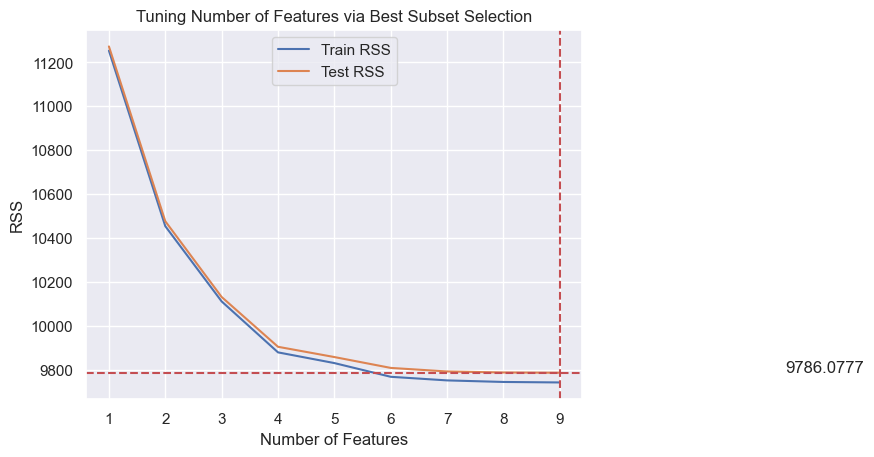

In [29]:
no_impute_models = f.best_subset(X, y)
best_subset, best_model, best_r2, best_rss = no_impute_models[0], no_impute_models[1], no_impute_models[2], no_impute_models[3]

In [30]:
# Fit model with statsmodels and view summary
best_model_no_impute = best_model
formula = "weather_id ~ " + "+".join(best_model_no_impute.feature_names_in_)
smf.ols(formula, df_new_1).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             weather_id   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                 1.416e+04
Date:                Sat, 30 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:44:23   Log-Likelihood:            -2.1687e+06
No. Observations:              360784   AIC:                         4.337e+06
Df Residuals:                  360774   BIC:                         4.337e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -664.4847     27.961    -23.765      0.000    -719.287    -609.682
temp          -4.0680      0.211    -19.248      0.000      -4.482      -3.654
visibility     0.0062   7.86e-05     78.359      0.000       0.006       0.006
dew_point      3.5039      0.224     15.616      0.000       3.064       3.944
pressure       1.7226      0.025     68.237      0.000       1.673       1.772
humidity      -2.3228      0.052    -44.586      0.000      -2.425      -2.221
wind_speed    -3.7299      0.079    -47.085      0.000      -3.885      -3.575
wind_deg       0.0150      0.002      9.103      0.000       0.012       0.018
clouds_all    -0.6600      0.005   -127.756      0.000      -0.670      -0.650
hour          -0.6203      0.026    -23.936      0.000      -0.671      -0.570
==============================================================================
Omnibus:                   118389.370   Durbin-Watson:                   1.294
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           374707.893
Skew:                          -1.703   Prob(JB):                         0.00
Kurtosis:                       6.651   Cond. No.                     1.55e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
df_new_2 = df_imputed.copy()
df_new_2.head()

,dt_iso,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,hour
0,1979-01-01 00:00:00+00:00,272.63,4000.000000,272.01,267.19,271.97,274.06,1012,95,5.70,40,90,741,0
1,1979-01-01 01:00:00+00:00,272.63,4000.000000,272.01,267.19,272.03,274.06,1012,95,5.70,40,90,741,1
2,1979-01-01 02:00:00+00:00,272.14,6797.954145,271.77,267.71,271.72,274.06,1011,97,3.89,9,100,804,2
3,1979-01-01 03:00:00+00:00,272.11,4000.000000,271.49,266.28,271.50,274.06,1010,95,6.20,20,90,741,3
4,1979-01-01 04:00:00+00:00,272.35,4000.000000,271.73,266.58,271.81,274.06,1010,95,6.20,20,90,741,4


In [32]:
df_new_2 = df_new_2.drop(labels=['dt_iso','feels_like', 'temp_min', 'temp_max' ], axis = 1)
df_new_2.head()

,temp,visibility,dew_point,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,hour
0,272.63,4000.000000,272.01,1012,95,5.70,40,90,741,0
1,272.63,4000.000000,272.01,1012,95,5.70,40,90,741,1
2,272.14,6797.954145,271.77,1011,97,3.89,9,100,804,2
3,272.11,4000.000000,271.49,1010,95,6.20,20,90,741,3
4,272.35,4000.000000,271.73,1010,95,6.20,20,90,741,4


In [33]:
df_new_2.sample(frac=1, random_state = 193).reset_index()
X, y = df_new_2.drop('weather_id', axis=1), df_new_2['weather_id']
X

,temp,visibility,dew_point,pressure,humidity,wind_speed,wind_deg,clouds_all,hour
0,272.63,4000.000000,272.01,1012,95,5.70,40,90,0
1,272.63,4000.000000,272.01,1012,95,5.70,40,90,1
2,272.14,6797.954145,271.77,1011,97,3.89,9,100,2
3,272.11,4000.000000,271.49,1010,95,6.20,20,90,3
4,272.35,4000.000000,271.73,1010,95,6.20,20,90,4
...,...,...,...,...,...,...,...,...,...
414842,280.50,10000.000000,272.83,1019,58,0.89,68,90,19
414843,281.07,10000.000000,273.09,1017,57,1.79,90,90,20
414844,280.75,10000.000000,272.17,1016,54,0.89,90,90,21
414845,280.14,10000.000000,270.75,1017,50,3.60,120,90,22


Best R2 with 9 Features: 0.2541: 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


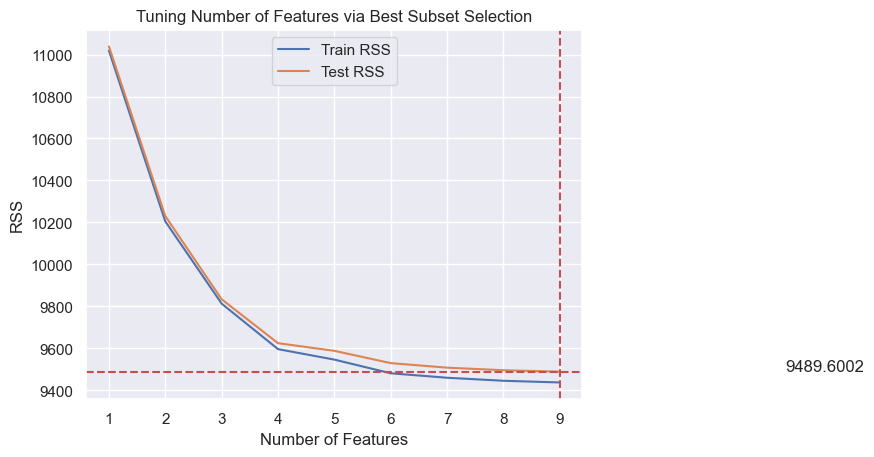

In [34]:
impute_models = f.best_subset(X, y)
best_subset, best_model, best_r2, best_rss = impute_models[0], impute_models[1], impute_models[2], impute_models[3]

In [35]:
# Fit model with statsmodels and view summary
best_model_impute = best_model
formula = "weather_id ~ " + "+".join(best_model_impute.feature_names_in_)
smf.ols(formula, df_new_2).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             weather_id   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                 1.571e+04
Date:                Sat, 30 Dec 2023   Prob (F-statistic):               0.00
Time:                        23:44:51   Log-Likelihood:            -2.4871e+06
No. Observations:              414847   AIC:                         4.974e+06
Df Residuals:                  414837   BIC:                         4.974e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -771.9730     25.923    -29.780      0.000    -822.780    -721.166
temp          -5.4233      0.197    -27.578      0.000      -5.809      -5.038
visibility     0.0061   7.66e-05     80.233      0.000       0.006       0.006
dew_point      4.9802      0.209     23.859      0.000       4.571       5.389
pressure       1.8263      0.023     78.233      0.000       1.781       1.872
humidity      -2.6545      0.048    -54.844      0.000      -2.749      -2.560
wind_speed    -4.2914      0.075    -57.319      0.000      -4.438      -4.145
wind_deg       0.0284      0.002     18.746      0.000       0.025       0.031
clouds_all    -0.5818      0.005   -126.045      0.000      -0.591      -0.573
hour          -0.7002      0.024    -29.541      0.000      -0.747      -0.654
==============================================================================
Omnibus:                   139192.978   Durbin-Watson:                   1.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           453967.355
Skew:                          -1.730   Prob(JB):                         0.00
Kurtosis:                       6.780   Cond. No.                     1.56e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

When comparing the 2 outputs, with or without imputation, we see the imputed data has a lower RSS score and all the p-values are near 0. 

### Regression Models

In [36]:
X, y = df_imputed.drop(['dt_iso', 'temp', 'dew_point', 'feels_like', 'temp_min', 'temp_max'], axis=1), df_imputed['temp']

In [37]:
X

,visibility,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,hour
0,4000.000000,1012,95,5.70,40,90,741,0
1,4000.000000,1012,95,5.70,40,90,741,1
2,6797.954145,1011,97,3.89,9,100,804,2
3,4000.000000,1010,95,6.20,20,90,741,3
4,4000.000000,1010,95,6.20,20,90,741,4
...,...,...,...,...,...,...,...,...
414842,10000.000000,1019,58,0.89,68,90,804,19
414843,10000.000000,1017,57,1.79,90,90,500,20
414844,10000.000000,1016,54,0.89,90,90,500,21
414845,10000.000000,1017,50,3.60,120,90,500,22


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=193)

#### Linear Regression

In [39]:
# Do a recursive function which loops to find the best Linear Regression model with the best R2 score for y = temp and x = [visibility	pressure	humidity	wind_speed	wind_deg	clouds_all	weather_id	hour]
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

features = ['visibility', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id', 'hour']

# Recursive function to generate subsets of features
def generate_feature_subsets(features, current_subset=[]):
    if not features:
        return [current_subset]
    return generate_feature_subsets(features[1:], current_subset) + generate_feature_subsets(features[1:], current_subset + [features[0]])


all_feature_subsets = generate_feature_subsets(features)
all_feature_subsets

[[],
 ['hour'],
 ['weather_id'],
 ['weather_id', 'hour'],
 ['clouds_all'],
 ['clouds_all', 'hour'],
 ['clouds_all', 'weather_id'],
 ['clouds_all', 'weather_id', 'hour'],
 ['wind_deg'],
 ['wind_deg', 'hour'],
 ['wind_deg', 'weather_id'],
 ['wind_deg', 'weather_id', 'hour'],
 ['wind_deg', 'clouds_all'],
 ['wind_deg', 'clouds_all', 'hour'],
 ['wind_deg', 'clouds_all', 'weather_id'],
 ['wind_deg', 'clouds_all', 'weather_id', 'hour'],
 ['wind_speed'],
 ['wind_speed', 'hour'],
 ['wind_speed', 'weather_id'],
 ['wind_speed', 'weather_id', 'hour'],
 ['wind_speed', 'clouds_all'],
 ['wind_speed', 'clouds_all', 'hour'],
 ['wind_speed', 'clouds_all', 'weather_id'],
 ['wind_speed', 'clouds_all', 'weather_id', 'hour'],
 ['wind_speed', 'wind_deg'],
 ['wind_speed', 'wind_deg', 'hour'],
 ['wind_speed', 'wind_deg', 'weather_id'],
 ['wind_speed', 'wind_deg', 'weather_id', 'hour'],
 ['wind_speed', 'wind_deg', 'clouds_all'],
 ['wind_speed', 'wind_deg', 'clouds_all', 'hour'],
 ['wind_speed', 'wind_deg', 'clo

In [40]:
all_feature_subsets = all_feature_subsets[1:]

In [41]:
best_model = None
best_r2_score = -math.inf

def find_best_linear_model(features_subset):
    global best_model, best_r2_score, X_train, X_test, y_train, y_test
    
    # Create and train the linear regression model
    model = LinearRegression()
    model.fit(X_train[features_subset], y_train)
    
    # Make predictions on the global testing set
    y_pred = model.predict(X_test[features_subset])
    
    # Calculate R-squared score
    r2 = r2_score(y_test, y_pred)
    
    # Update the best model if the current model has a higher R-squared score
    if r2 > best_r2_score:
        best_r2_score = r2
        best_model = model
    
    tqdm.write(f"Features: {features_subset}, R-squared: {r2}")

for subset in tqdm(all_feature_subsets, desc="Feature Subsets", leave=False):
    find_best_linear_model(subset)

# Print the best features and R-squared score
print("\nBest Features:", best_model)
print("Best R-squared Score:", best_r2_score)
print("Best Features Names:", features)

Feature Subsets:   2%|▏         | 5/255 [00:00<00:06, 38.85it/s]

Features: ['hour'], R-squared: 0.016555809894162166
Features: ['weather_id'], R-squared: 0.00022671729660428408
Features: ['weather_id', 'hour'], R-squared: 0.016872990799787213
Features: ['clouds_all'], R-squared: 0.022525124728399182
Features: ['clouds_all', 'hour'], R-squared: 0.04253142807215704
Features: ['clouds_all', 'weather_id'], R-squared: 0.02411134740293852
Features: ['clouds_all', 'weather_id', 'hour'], R-squared: 0.0443245234181503


Feature Subsets:   5%|▍         | 12/255 [00:00<00:08, 27.29it/s]

Features: ['wind_deg'], R-squared: 0.0021050089568724895
Features: ['wind_deg', 'hour'], R-squared: 0.019945666977902343
Features: ['wind_deg', 'weather_id'], R-squared: 0.0023800683368164766
Features: ['wind_deg', 'weather_id', 'hour'], R-squared: 0.020284423290905518
Features: ['wind_deg', 'clouds_all'], R-squared: 0.023863732373481716


Feature Subsets:   8%|▊         | 20/255 [00:00<00:07, 31.87it/s]

Features: ['wind_deg', 'clouds_all', 'hour'], R-squared: 0.04492972724374544
Features: ['wind_deg', 'clouds_all', 'weather_id'], R-squared: 0.025349307780054953
Features: ['wind_deg', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.046585622592252185
Features: ['wind_speed'], R-squared: 0.0026038366641615296
Features: ['wind_speed', 'hour'], R-squared: 0.022608743624789485
Features: ['wind_speed', 'weather_id'], R-squared: 0.002702593078432791
Features: ['wind_speed', 'weather_id', 'hour'], R-squared: 0.02267912014579454
Features: ['wind_speed', 'clouds_all'], R-squared: 0.022827879540422424


Feature Subsets:   9%|▉         | 24/255 [00:00<00:07, 30.38it/s]

Features: ['wind_speed', 'clouds_all', 'hour'], R-squared: 0.04444151615757974
Features: ['wind_speed', 'clouds_all', 'weather_id'], R-squared: 0.024472588797189276
Features: ['wind_speed', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.04640884935190093
Features: ['wind_speed', 'wind_deg'], R-squared: 0.00351459054129466
Features: ['wind_speed', 'wind_deg', 'hour'], R-squared: 0.02375462191419353
Features: ['wind_speed', 'wind_deg', 'weather_id'], R-squared: 0.0036493730177332706


Feature Subsets:  12%|█▏        | 31/255 [00:01<00:08, 25.51it/s]

Features: ['wind_speed', 'wind_deg', 'weather_id', 'hour'], R-squared: 0.02385983890715604
Features: ['wind_speed', 'wind_deg', 'clouds_all'], R-squared: 0.02388617331926024
Features: ['wind_speed', 'wind_deg', 'clouds_all', 'hour'], R-squared: 0.04576971312808109
Features: ['wind_speed', 'wind_deg', 'clouds_all', 'weather_id'], R-squared: 0.025397408022276524
Features: ['wind_speed', 'wind_deg', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.04757585062208847
Features: ['humidity'], R-squared: 0.06746243515337802


Features: ['humidity', 'hour'], R-squared: 0.07047108310566286
Features: ['humidity', 'weather_id'], R-squared: 0.07384400887612408
Features: ['humidity', 'weather_id', 'hour'], R-squared: 0.07585807404924771
Features: ['humidity', 'clouds_all'], R-squared: 0.07344774379628516
Features: ['humidity', 'clouds_all', 'hour'], R-squared: 0.07838454943633433
Features: ['humidity', 'clouds_all', 'weather_id'], R-squared: 0.08472673753320692


Feature Subsets:  17%|█▋        | 43/255 [00:01<00:07, 29.42it/s]

Features: ['humidity', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.08854035391182502
Features: ['humidity', 'wind_deg'], R-squared: 0.07436104533410781
Features: ['humidity', 'wind_deg', 'hour'], R-squared: 0.07788472215536668
Features: ['humidity', 'wind_deg', 'weather_id'], R-squared: 0.08132805662877851
Features: ['humidity', 'wind_deg', 'weather_id', 'hour'], R-squared: 0.08374024764361532
Features: ['humidity', 'wind_deg', 'clouds_all'], R-squared: 0.07905209786270229
Features: ['humidity', 'wind_deg', 'clouds_all', 'hour'], R-squared: 0.08435628587048416


Feature Subsets:  20%|█▉        | 50/255 [00:01<00:07, 26.53it/s]

Features: ['humidity', 'wind_deg', 'clouds_all', 'weather_id'], R-squared: 0.0905099641730861
Features: ['humidity', 'wind_deg', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.09464373387501224
Features: ['humidity', 'wind_speed'], R-squared: 0.07760565085764959
Features: ['humidity', 'wind_speed', 'hour'], R-squared: 0.08259248327898239
Features: ['humidity', 'wind_speed', 'weather_id'], R-squared: 0.08801408702377667
Features: ['humidity', 'wind_speed', 'weather_id', 'hour'], R-squared: 0.0916669832095377


Feature Subsets:  22%|██▏       | 57/255 [00:02<00:07, 28.04it/s]

Features: ['humidity', 'wind_speed', 'clouds_all'], R-squared: 0.08003857687529525
Features: ['humidity', 'wind_speed', 'clouds_all', 'hour'], R-squared: 0.0862405640750058
Features: ['humidity', 'wind_speed', 'clouds_all', 'weather_id'], R-squared: 0.09378584544540769
Features: ['humidity', 'wind_speed', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.09877977612727717
Features: ['humidity', 'wind_speed', 'wind_deg'], R-squared: 0.08036914260560502
Features: ['humidity', 'wind_speed', 'wind_deg', 'hour'], R-squared: 0.08538902750331345


Feature Subsets:  24%|██▎       | 60/255 [00:02<00:06, 28.03it/s]

Features: ['humidity', 'wind_speed', 'wind_deg', 'weather_id'], R-squared: 0.09050699897904213
Features: ['humidity', 'wind_speed', 'wind_deg', 'weather_id', 'hour'], R-squared: 0.0942033876307603
Features: ['humidity', 'wind_speed', 'wind_deg', 'clouds_all'], R-squared: 0.0827345149870059
Features: ['humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'hour'], R-squared: 0.08895799397106896
Features: ['humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id'], R-squared: 0.09613087625486127


Feature Subsets:  26%|██▌       | 66/255 [00:02<00:07, 26.76it/s]

Features: ['humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.10115748406240976
Features: ['pressure'], R-squared: 0.0373215214401309
Features: ['pressure', 'hour'], R-squared: 0.05365533245416643
Features: ['pressure', 'weather_id'], R-squared: 0.04338816038989679
Features: ['pressure', 'weather_id', 'hour'], R-squared: 0.0599563046891487
Features: ['pressure', 'clouds_all'], R-squared: 0.08338453244102839


Feature Subsets:  28%|██▊       | 72/255 [00:02<00:07, 25.64it/s]

Features: ['pressure', 'clouds_all', 'hour'], R-squared: 0.1047333911714593
Features: ['pressure', 'clouds_all', 'weather_id'], R-squared: 0.08359812163580949
Features: ['pressure', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.10489294059194587
Features: ['pressure', 'wind_deg'], R-squared: 0.043154957652236425
Features: ['pressure', 'wind_deg', 'hour'], R-squared: 0.061472984316081836
Features: ['pressure', 'wind_deg', 'weather_id'], R-squared: 0.049956296221914664


Feature Subsets:  31%|███       | 78/255 [00:02<00:07, 24.62it/s]

Features: ['pressure', 'wind_deg', 'weather_id', 'hour'], R-squared: 0.06866140152014633
Features: ['pressure', 'wind_deg', 'clouds_all'], R-squared: 0.08850073009069004
Features: ['pressure', 'wind_deg', 'clouds_all', 'hour'], R-squared: 0.11195760008561195
Features: ['pressure', 'wind_deg', 'clouds_all', 'weather_id'], R-squared: 0.08888260805494408
Features: ['pressure', 'wind_deg', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.11229571331510901


Features: ['pressure', 'wind_speed'], R-squared: 0.049474124485922255
Features: ['pressure', 'wind_speed', 'hour'], R-squared: 0.07287683776871301
Features: ['pressure', 'wind_speed', 'weather_id'], R-squared: 0.05490959148934782
Features: ['pressure', 'wind_speed', 'weather_id', 'hour'], R-squared: 0.07840177723782271
Features: ['pressure', 'wind_speed', 'clouds_all'], R-squared: 0.08925650783837136


Feature Subsets:  34%|███▍      | 87/255 [00:03<00:07, 23.44it/s]

Features: ['pressure', 'wind_speed', 'clouds_all', 'hour'], R-squared: 0.11604014628581971
Features: ['pressure', 'wind_speed', 'clouds_all', 'weather_id'], R-squared: 0.08949101758508671
Features: ['pressure', 'wind_speed', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.11621726090283446
Features: ['pressure', 'wind_speed', 'wind_deg'], R-squared: 0.05133244648260549
Features: ['pressure', 'wind_speed', 'wind_deg', 'hour'], R-squared: 0.07513986832366815


Feature Subsets:  36%|███▋      | 93/255 [00:03<00:06, 23.86it/s]

Features: ['pressure', 'wind_speed', 'wind_deg', 'weather_id'], R-squared: 0.05728448660116192
Features: ['pressure', 'wind_speed', 'wind_deg', 'weather_id', 'hour'], R-squared: 0.08123891117647941
Features: ['pressure', 'wind_speed', 'wind_deg', 'clouds_all'], R-squared: 0.09169791164123653
Features: ['pressure', 'wind_speed', 'wind_deg', 'clouds_all', 'hour'], R-squared: 0.11900714302597859
Features: ['pressure', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id'], R-squared: 0.09204992916781962


Feature Subsets:  39%|███▉      | 99/255 [00:03<00:06, 22.44it/s]

Features: ['pressure', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.11929939337663786
Features: ['pressure', 'humidity'], R-squared: 0.13129110338932892
Features: ['pressure', 'humidity', 'hour'], R-squared: 0.13266233913733494
Features: ['pressure', 'humidity', 'weather_id'], R-squared: 0.1316022181210177
Features: ['pressure', 'humidity', 'weather_id', 'hour'], R-squared: 0.1328424497143771


Feature Subsets:  40%|████      | 102/255 [00:03<00:06, 22.86it/s]

Features: ['pressure', 'humidity', 'clouds_all'], R-squared: 0.15163259385643169
Features: ['pressure', 'humidity', 'clouds_all', 'hour'], R-squared: 0.15553676423574203
Features: ['pressure', 'humidity', 'clouds_all', 'weather_id'], R-squared: 0.15445218138940997
Features: ['pressure', 'humidity', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.15787500864422677
Features: ['pressure', 'humidity', 'wind_deg'], R-squared: 0.14879492556127272


Feature Subsets:  42%|████▏     | 108/255 [00:04<00:05, 25.02it/s]

Features: ['pressure', 'humidity', 'wind_deg', 'hour'], R-squared: 0.15060120526958565
Features: ['pressure', 'humidity', 'wind_deg', 'weather_id'], R-squared: 0.14908674456001803
Features: ['pressure', 'humidity', 'wind_deg', 'weather_id', 'hour'], R-squared: 0.1507500687391199
Features: ['pressure', 'humidity', 'wind_deg', 'clouds_all'], R-squared: 0.16667137495585316
Features: ['pressure', 'humidity', 'wind_deg', 'clouds_all', 'hour'], R-squared: 0.17104574152853225


Feature Subsets:  44%|████▎     | 111/255 [00:04<00:06, 23.14it/s]

Features: ['pressure', 'humidity', 'wind_deg', 'clouds_all', 'weather_id'], R-squared: 0.16921791502477046
Features: ['pressure', 'humidity', 'wind_deg', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.17310480121868188
Features: ['pressure', 'humidity', 'wind_speed'], R-squared: 0.1696059606815875
Features: ['pressure', 'humidity', 'wind_speed', 'hour'], R-squared: 0.17365882457092274


Feature Subsets:  46%|████▌     | 117/255 [00:04<00:06, 21.83it/s]

Features: ['pressure', 'humidity', 'wind_speed', 'weather_id'], R-squared: 0.1714585625395656
Features: ['pressure', 'humidity', 'wind_speed', 'weather_id', 'hour'], R-squared: 0.1750144160823277
Features: ['pressure', 'humidity', 'wind_speed', 'clouds_all'], R-squared: 0.17927918041489466
Features: ['pressure', 'humidity', 'wind_speed', 'clouds_all', 'hour'], R-squared: 0.18548511209277863
Features: ['pressure', 'humidity', 'wind_speed', 'clouds_all', 'weather_id'], R-squared: 0.18360075599753334


Feature Subsets:  47%|████▋     | 120/255 [00:04<00:06, 19.44it/s]

Features: ['pressure', 'humidity', 'wind_speed', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.18911544397708868
Features: ['pressure', 'humidity', 'wind_speed', 'wind_deg'], R-squared: 0.1757936634408933
Features: ['pressure', 'humidity', 'wind_speed', 'wind_deg', 'hour'], R-squared: 0.1798714801243151
Features: ['pressure', 'humidity', 'wind_speed', 'wind_deg', 'weather_id'], R-squared: 0.17736389379660822


Feature Subsets:  49%|████▉     | 126/255 [00:05<00:06, 20.06it/s]

Features: ['pressure', 'humidity', 'wind_speed', 'wind_deg', 'weather_id', 'hour'], R-squared: 0.1809835004224175
Features: ['pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all'], R-squared: 0.18547423453939205
Features: ['pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'hour'], R-squared: 0.19171258398453672
Features: ['pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id'], R-squared: 0.18935171496252012
Features: ['pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.1949322994492163


Feature Subsets:  52%|█████▏    | 132/255 [00:05<00:05, 24.06it/s]

Features: ['visibility'], R-squared: 0.02509521356835298
Features: ['visibility', 'hour'], R-squared: 0.041299409347959726
Features: ['visibility', 'weather_id'], R-squared: 0.026970428004612357
Features: ['visibility', 'weather_id', 'hour'], R-squared: 0.04299047022849567
Features: ['visibility', 'clouds_all'], R-squared: 0.03549305246080681
Features: ['visibility', 'clouds_all', 'hour'], R-squared: 0.05426791930646424


Feature Subsets:  54%|█████▍    | 138/255 [00:05<00:04, 26.09it/s]

Features: ['visibility', 'clouds_all', 'weather_id'], R-squared: 0.040845344970806274
Features: ['visibility', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.05976424054627538
Features: ['visibility', 'wind_deg'], R-squared: 0.027972400307739287
Features: ['visibility', 'wind_deg', 'hour'], R-squared: 0.04558392138547873
Features: ['visibility', 'wind_deg', 'weather_id'], R-squared: 0.029882163140425355
Features: ['visibility', 'wind_deg', 'weather_id', 'hour'], R-squared: 0.047306932311618866


Feature Subsets:  55%|█████▌    | 141/255 [00:05<00:04, 25.07it/s]

Features: ['visibility', 'wind_deg', 'clouds_all'], R-squared: 0.037520127653189905
Features: ['visibility', 'wind_deg', 'clouds_all', 'hour'], R-squared: 0.057481156723599436
Features: ['visibility', 'wind_deg', 'clouds_all', 'weather_id'], R-squared: 0.04276668767525438
Features: ['visibility', 'wind_deg', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.06284735556938958
Features: ['visibility', 'wind_speed'], R-squared: 0.027219336880616396


Feature Subsets:  59%|█████▉    | 150/255 [00:05<00:04, 23.67it/s]

Features: ['visibility', 'wind_speed', 'hour'], R-squared: 0.04650944359305542
Features: ['visibility', 'wind_speed', 'weather_id'], R-squared: 0.029612337722447868
Features: ['visibility', 'wind_speed', 'weather_id', 'hour'], R-squared: 0.04897609702899819
Features: ['visibility', 'wind_speed', 'clouds_all'], R-squared: 0.03602595080782356
Features: ['visibility', 'wind_speed', 'clouds_all', 'hour'], R-squared: 0.05660849334027207
Features: ['visibility', 'wind_speed', 'clouds_all', 'weather_id'], R-squared: 0.04158759533882206


Feature Subsets:  61%|██████    | 156/255 [00:06<00:03, 24.97it/s]

Features: ['visibility', 'wind_speed', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.06255638692590848
Features: ['visibility', 'wind_speed', 'wind_deg'], R-squared: 0.02881841704899013
Features: ['visibility', 'wind_speed', 'wind_deg', 'hour'], R-squared: 0.04839821046868076
Features: ['visibility', 'wind_speed', 'wind_deg', 'weather_id'], R-squared: 0.031077751997775405
Features: ['visibility', 'wind_speed', 'wind_deg', 'weather_id', 'hour'], R-squared: 0.05071784349302788
Features: ['visibility', 'wind_speed', 'wind_deg', 'clouds_all'], R-squared: 0.037585487200878065


Feature Subsets:  64%|██████▎   | 162/255 [00:06<00:03, 23.45it/s]

Features: ['visibility', 'wind_speed', 'wind_deg', 'clouds_all', 'hour'], R-squared: 0.05846144767343753
Features: ['visibility', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id'], R-squared: 0.04293326406110831
Features: ['visibility', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.06417062867644485
Features: ['visibility', 'humidity'], R-squared: 0.06859676559208283
Features: ['visibility', 'humidity', 'hour'], R-squared: 0.0723478482953347
Features: ['visibility', 'humidity', 'weather_id'], R-squared: 0.07665893974742577


Feature Subsets:  65%|██████▍   | 165/255 [00:06<00:03, 23.79it/s]

Features: ['visibility', 'humidity', 'weather_id', 'hour'], R-squared: 0.0794547724139626
Features: ['visibility', 'humidity', 'clouds_all'], R-squared: 0.07369320414633729
Features: ['visibility', 'humidity', 'clouds_all', 'hour'], R-squared: 0.07899992053973981
Features: ['visibility', 'humidity', 'clouds_all', 'weather_id'], R-squared: 0.0858983925040897
Features: ['visibility', 'humidity', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.09027333784641922


Feature Subsets:  67%|██████▋   | 171/255 [00:06<00:03, 23.94it/s]

Features: ['visibility', 'humidity', 'wind_deg'], R-squared: 0.07535329886509301
Features: ['visibility', 'humidity', 'wind_deg', 'hour'], R-squared: 0.0796319227360125
Features: ['visibility', 'humidity', 'wind_deg', 'weather_id'], R-squared: 0.08398651111652822
Features: ['visibility', 'humidity', 'wind_deg', 'weather_id', 'hour'], R-squared: 0.08722496938431845
Features: ['visibility', 'humidity', 'wind_deg', 'clouds_all'], R-squared: 0.07929884255709074


Feature Subsets:  68%|██████▊   | 174/255 [00:07<00:03, 22.59it/s]

Features: ['visibility', 'humidity', 'wind_deg', 'clouds_all', 'hour'], R-squared: 0.084990184949017
Features: ['visibility', 'humidity', 'wind_deg', 'clouds_all', 'weather_id'], R-squared: 0.09169273107244624
Features: ['visibility', 'humidity', 'wind_deg', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.09641594290468292
Features: ['visibility', 'humidity', 'wind_speed'], R-squared: 0.077972292663125


Feature Subsets:  71%|███████   | 180/255 [00:07<00:03, 21.00it/s]

Features: ['visibility', 'humidity', 'wind_speed', 'hour'], R-squared: 0.08348051413632096
Features: ['visibility', 'humidity', 'wind_speed', 'weather_id'], R-squared: 0.08966724105559809
Features: ['visibility', 'humidity', 'wind_speed', 'weather_id', 'hour'], R-squared: 0.09405477606030588
Features: ['visibility', 'humidity', 'wind_speed', 'clouds_all'], R-squared: 0.08012105106481315
Features: ['visibility', 'humidity', 'wind_speed', 'clouds_all', 'hour'], R-squared: 0.08659061956577463


Feature Subsets:  72%|███████▏  | 183/255 [00:07<00:03, 19.95it/s]

Features: ['visibility', 'humidity', 'wind_speed', 'clouds_all', 'weather_id'], R-squared: 0.09459693895583332
Features: ['visibility', 'humidity', 'wind_speed', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.10011275127914243
Features: ['visibility', 'humidity', 'wind_speed', 'wind_deg'], R-squared: 0.08078645925293726
Features: ['visibility', 'humidity', 'wind_speed', 'wind_deg', 'hour'], R-squared: 0.08635883198482086


Feature Subsets:  74%|███████▍  | 189/255 [00:07<00:03, 18.84it/s]

Features: ['visibility', 'humidity', 'wind_speed', 'wind_deg', 'weather_id'], R-squared: 0.09223999105091885
Features: ['visibility', 'humidity', 'wind_speed', 'wind_deg', 'weather_id', 'hour'], R-squared: 0.09669366211848385
Features: ['visibility', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all'], R-squared: 0.08284581342654196
Features: ['visibility', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'hour'], R-squared: 0.08936570259115517


Feature Subsets:  75%|███████▍  | 191/255 [00:08<00:03, 16.46it/s]

Features: ['visibility', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id'], R-squared: 0.09700688875872865
Features: ['visibility', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.10257645980176455
Features: ['visibility', 'pressure'], R-squared: 0.08306969196407044
Features: ['visibility', 'pressure', 'hour'], R-squared: 0.09879776014845787


Feature Subsets:  77%|███████▋  | 197/255 [00:08<00:02, 20.74it/s]

Features: ['visibility', 'pressure', 'weather_id'], R-squared: 0.08324283610059557
Features: ['visibility', 'pressure', 'weather_id', 'hour'], R-squared: 0.09902704883955693
Features: ['visibility', 'pressure', 'clouds_all'], R-squared: 0.10836203074230955
Features: ['visibility', 'pressure', 'clouds_all', 'hour'], R-squared: 0.12805626663460734
Features: ['visibility', 'pressure', 'clouds_all', 'weather_id'], R-squared: 0.10891519388199933


Feature Subsets:  80%|███████▉  | 203/255 [00:08<00:02, 22.15it/s]

Features: ['visibility', 'pressure', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.12864276830444676
Features: ['visibility', 'pressure', 'wind_deg'], R-squared: 0.09220056974821522
Features: ['visibility', 'pressure', 'wind_deg', 'hour'], R-squared: 0.110327368770339
Features: ['visibility', 'pressure', 'wind_deg', 'weather_id'], R-squared: 0.09246662181932286
Features: ['visibility', 'pressure', 'wind_deg', 'weather_id', 'hour'], R-squared: 0.11068280064358638
Features: ['visibility', 'pressure', 'wind_deg', 'clouds_all'], R-squared: 0.11603449503623364


Feature Subsets:  82%|████████▏ | 209/255 [00:08<00:02, 20.88it/s]

Features: ['visibility', 'pressure', 'wind_deg', 'clouds_all', 'hour'], R-squared: 0.13808157511103392
Features: ['visibility', 'pressure', 'wind_deg', 'clouds_all', 'weather_id'], R-squared: 0.11641204656864457
Features: ['visibility', 'pressure', 'wind_deg', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.1384648136284442
Features: ['visibility', 'pressure', 'wind_speed'], R-squared: 0.09720895424249165
Features: ['visibility', 'pressure', 'wind_speed', 'hour'], R-squared: 0.12038902924526951


Feature Subsets:  83%|████████▎ | 212/255 [00:09<00:02, 19.71it/s]

Features: ['visibility', 'pressure', 'wind_speed', 'weather_id'], R-squared: 0.09725474688983216
Features: ['visibility', 'pressure', 'wind_speed', 'weather_id', 'hour'], R-squared: 0.1204462580459803
Features: ['visibility', 'pressure', 'wind_speed', 'clouds_all'], R-squared: 0.1167589018685079
Features: ['visibility', 'pressure', 'wind_speed', 'clouds_all', 'hour'], R-squared: 0.14246969634235218
Features: ['visibility', 'pressure', 'wind_speed', 'clouds_all', 'weather_id'], R-squared: 0.11736395682116041


Feature Subsets:  85%|████████▌ | 218/255 [00:09<00:01, 19.96it/s]

Features: ['visibility', 'pressure', 'wind_speed', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.14313505909874558
Features: ['visibility', 'pressure', 'wind_speed', 'wind_deg'], R-squared: 0.10088992820509668
Features: ['visibility', 'pressure', 'wind_speed', 'wind_deg', 'hour'], R-squared: 0.1246262739783135
Features: ['visibility', 'pressure', 'wind_speed', 'wind_deg', 'weather_id'], R-squared: 0.100989561307261


Feature Subsets:  87%|████████▋ | 221/255 [00:09<00:01, 19.33it/s]

Features: ['visibility', 'pressure', 'wind_speed', 'wind_deg', 'weather_id', 'hour'], R-squared: 0.12474778704778922
Features: ['visibility', 'pressure', 'wind_speed', 'wind_deg', 'clouds_all'], R-squared: 0.12057237553522582
Features: ['visibility', 'pressure', 'wind_speed', 'wind_deg', 'clouds_all', 'hour'], R-squared: 0.1468907214660503
Features: ['visibility', 'pressure', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id'], R-squared: 0.12102692345235877


Feature Subsets:  89%|████████▊ | 226/255 [00:09<00:01, 20.11it/s]

Features: ['visibility', 'pressure', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.14738723189383018
Features: ['visibility', 'pressure', 'humidity'], R-squared: 0.1375147892399925
Features: ['visibility', 'pressure', 'humidity', 'hour'], R-squared: 0.14000705472099628
Features: ['visibility', 'pressure', 'humidity', 'weather_id'], R-squared: 0.13862466556049324
Features: ['visibility', 'pressure', 'humidity', 'weather_id', 'hour'], R-squared: 0.14084796237948372


Feature Subsets:  91%|█████████ | 232/255 [00:09<00:01, 20.49it/s]

Features: ['visibility', 'pressure', 'humidity', 'clouds_all'], R-squared: 0.15420957345249742
Features: ['visibility', 'pressure', 'humidity', 'clouds_all', 'hour'], R-squared: 0.1590198036051168
Features: ['visibility', 'pressure', 'humidity', 'clouds_all', 'weather_id'], R-squared: 0.15797910573064378
Features: ['visibility', 'pressure', 'humidity', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.16230254633364627
Features: ['visibility', 'pressure', 'humidity', 'wind_deg'], R-squared: 0.15514733870128217


Feature Subsets:  92%|█████████▏| 235/255 [00:10<00:00, 20.66it/s]

Features: ['visibility', 'pressure', 'humidity', 'wind_deg', 'hour'], R-squared: 0.1582413620676053
Features: ['visibility', 'pressure', 'humidity', 'wind_deg', 'weather_id'], R-squared: 0.15623008656326753
Features: ['visibility', 'pressure', 'humidity', 'wind_deg', 'weather_id', 'hour'], R-squared: 0.15902901735122366
Features: ['visibility', 'pressure', 'humidity', 'wind_deg', 'clouds_all'], R-squared: 0.16951759291068602
Features: ['visibility', 'pressure', 'humidity', 'wind_deg', 'clouds_all', 'hour'], R-squared: 0.17490677980490033


Feature Subsets:  95%|█████████▍| 241/255 [00:10<00:00, 18.84it/s]

Features: ['visibility', 'pressure', 'humidity', 'wind_deg', 'clouds_all', 'weather_id'], R-squared: 0.1730099116006516
Features: ['visibility', 'pressure', 'humidity', 'wind_deg', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.1778984550149767
Features: ['visibility', 'pressure', 'humidity', 'wind_speed'], R-squared: 0.17327079158050573
Features: ['visibility', 'pressure', 'humidity', 'wind_speed', 'hour'], R-squared: 0.17862760364623653


Feature Subsets:  96%|█████████▋| 246/255 [00:10<00:00, 19.44it/s]

Features: ['visibility', 'pressure', 'humidity', 'wind_speed', 'weather_id'], R-squared: 0.17628734286291636
Features: ['visibility', 'pressure', 'humidity', 'wind_speed', 'weather_id', 'hour'], R-squared: 0.18107666594731042
Features: ['visibility', 'pressure', 'humidity', 'wind_speed', 'clouds_all'], R-squared: 0.181109282523226
Features: ['visibility', 'pressure', 'humidity', 'wind_speed', 'clouds_all', 'hour'], R-squared: 0.18826010954538386
Features: ['visibility', 'pressure', 'humidity', 'wind_speed', 'clouds_all', 'weather_id'], R-squared: 0.1864109133509052


Feature Subsets:  98%|█████████▊| 250/255 [00:10<00:00, 18.10it/s]

Features: ['visibility', 'pressure', 'humidity', 'wind_speed', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.1929227577599033
Features: ['visibility', 'pressure', 'humidity', 'wind_speed', 'wind_deg'], R-squared: 0.17981331833165803
Features: ['visibility', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'hour'], R-squared: 0.1852629663690608
Features: ['visibility', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'weather_id'], R-squared: 0.18250533378875677


Feature Subsets: 100%|█████████▉| 254/255 [00:11<00:00, 16.58it/s]

Features: ['visibility', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'weather_id', 'hour'], R-squared: 0.18741270347538086
Features: ['visibility', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all'], R-squared: 0.18756093914733962
Features: ['visibility', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'hour'], R-squared: 0.1948083672113453
Features: ['visibility', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id'], R-squared: 0.19241297566346505


Features: ['visibility', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id', 'hour'], R-squared: 0.19904164505768918

Best Features: LinearRegression()
Best R-squared Score: 0.19904164505768918
Best Features Names: ['visibility', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'weather_id', 'hour']


In [42]:
# Initialize variables to track the best model and its R-squared score
best_model = None
best_r2_score = 0

lr_model = LinearRegression().fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

In [43]:
print("R2 Value is %.4f" %r2)


R2 Value is 0.1990


#### Ridge Regression

In [44]:
# Code for ridge regression
ridge_model = Ridge(alpha=0.5).fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print("R2 Value is %.4f" %r2)

R2 Value is 0.1990


#### Lasso Regression

In [45]:
# Code for Lasso Regression
lasso_model = Lasso(alpha=0.001).fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print("R2 Value is %.4f" %r2)

R2 Value is 0.1990


#### Elastic Net

In [46]:
# Code for Elastic Net Regression
elastic_model = ElasticNet(alpha=0.001).fit(X_train, y_train)
y_pred = elastic_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print("R2 Value is %.4f" %r2)

R2 Value is 0.1990


#### Decision Tree Regression

In [47]:
# Code for Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor().fit(X_train, y_train)
y_pred = tree_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print("R2 Value is %.4f" %r2)

R2 Value is 0.1717


#### Random Forest 

In [48]:
# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
forest_model = RandomForestRegressor().fit(X_train, y_train)
y_pred = forest_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print("R2 Value is %.4f" %r2)

KeyboardInterrupt: 

#### Gradient BOosting Regression

In [ ]:
# Code for Gradient Boosting Regression
from sklearn.ensemble import GradientBoostingRegressor
boost_model = GradientBoostingRegressor().fit(X_train, y_train)
y_pred = boost_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print("R2 Value is %.4f" %r2)

R2 Value is 0.4410


#### Support Vector Regressor

##### Support Vector Regression
from sklearn.svm import SVR
svr_model = SVR().fit(X_train, y_train)
y_pred = svr_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print("R2 Value is %.4f" %r2)   

#### Neural Networks

In [ ]:
# Run a Neural Network using Keras
kmodel = Sequential()
kmodel.add(Dense(64, activation='relu', input_dim=8))
kmodel.add(Dense(64, activation='relu'))
kmodel.add(Dense(1, activation='linear'))

kmodel.compile(optimizer='adam', loss='mse', metrics=['mse'])

kmodel.fit(X_train, y_train, epochs=100, batch_size=32)

y_pred = kmodel.predict(X_test)
r2 = r2_score(y_test, y_pred)

print("R2 Value is %.4f" %r2)

Epoch 1/100


2023-12-29 22:19:43.835726: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-12-29 22:19:43.835851: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-29 22:19:43.835884: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-29 22:19:43.836028: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-29 22:19:43.836045: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


    1/10372 [..............................] - ETA: 50:37 - loss: 8325831.5000 - mse: 8325831.5000

2023-12-29 22:19:44.166133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10372/10372 [==============================] - 49s 5ms/step - loss: 3016.1204 - mse: 3016.1204
Epoch 2/100
10372/10372 [==============================] - 49s 5ms/step - loss: 444.2966 - mse: 444.2966
Epoch 3/100
10372/10372 [==============================] - 49s 5ms/step - loss: 482.1219 - mse: 482.1219
Epoch 4/100
10372/10372 [==============================] - 49s 5ms/step - loss: 602.7203 - mse: 602.7203
Epoch 5/100
10372/10372 [==============================] - 48s 5ms/step - loss: 866.6748 - mse: 866.6748
Epoch 6/100
10372/10372 [==============================] - 48s 5ms/step - loss: 1193.2749 - mse: 1193.2749
Epoch 7/100
10372/10372 [==============================] - 49s 5ms/step - loss: 1449.4943 - mse: 1449.4943
Epoch 8/100
10372/10372 [==============================] - 48s 5ms/step - loss: 1794.0322 - mse: 1794.0322
Epoch 9/100
10372/10372 [==============================] - 48s 5ms/step - loss: 1904.4135 - mse: 1904.4135
Epoch 10/100
10372/10372 [==============================]

2023-12-29 23:39:20.888741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2593/2593 [==============================] - 3s 1ms/step
R2 Value is -76.2567


#### Gaussian Process Regression

##### Gaussian Process Regression
from sklearn.gaussian_process import GaussianProcessRegressor
gp_model = GaussianProcessRegressor().fit(X_train, y_train)
y_pred = gp_model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print("R2 Value is %.4f" %r2)

In [ ]:
# Pickle the models
import pickle
pickle.dump(lr_model, open('models/Regression/Linear_Regression.pkl', 'wb'))
pickle.dump(ridge_model, open('models/Regression/Ridge_Regression.pkl', 'wb'))
pickle.dump(lasso_model, open('models/Regression/Lasso_Regression.pkl', 'wb'))
pickle.dump(elastic_model, open('models/Regression/Elastic_Regression.pkl', 'wb'))
pickle.dump(tree_model, open('models/Regression/Decision_Tree_Regression.pkl', 'wb'))
pickle.dump(forest_model, open('models/Regression/Random_Forest_Regression.pkl', 'wb'))
pickle.dump(boost_model, open('models/Regression/Gradient_Boosting_Regression.pkl', 'wb'))
# pickle.dump(svr_model, open('models/Regression/Support_Vector_Regression.pkl', 'wb'))
pickle.dump(kmodel, open('models/Regression/Neural_Network_Regression_Keras.pkl', 'wb'))
#pickle.dump(gp_model, open('models/Regression/Gaussian_Process_Regression.pkl', 'wb'))


### Classification Models

#### Data Processing

In [52]:
### Logistic Regression for Classification

X_c, y_c = df_imputed.drop(['dt_iso', 'weather_id', 'dew_point', 'feels_like', 'temp_min', 'temp_max'], axis= 1), df_imputed['weather_id']
X_c

,temp,visibility,pressure,humidity,wind_speed,wind_deg,clouds_all,hour
0,272.63,4000.000000,1012,95,5.70,40,90,0
1,272.63,4000.000000,1012,95,5.70,40,90,1
2,272.14,6797.954145,1011,97,3.89,9,100,2
3,272.11,4000.000000,1010,95,6.20,20,90,3
4,272.35,4000.000000,1010,95,6.20,20,90,4
...,...,...,...,...,...,...,...,...
414842,280.50,10000.000000,1019,58,0.89,68,90,19
414843,281.07,10000.000000,1017,57,1.79,90,90,20
414844,280.75,10000.000000,1016,54,0.89,90,90,21
414845,280.14,10000.000000,1017,50,3.60,120,90,22


In [53]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_c, y_c, test_size=0.2, random_state=193)

In [84]:
Xc_train

,temp,visibility,pressure,humidity,wind_speed,wind_deg,clouds_all,hour
42732,295.16,10082.809856,1019,59,3.66,14,17,16
161050,261.49,10000.000000,1033,47,5.20,300,1,0
148282,283.69,8086.094804,1020,88,3.36,224,100,3
291703,268.72,10000.000000,1018,76,5.70,50,90,1
48448,278.68,10000.000000,1014,52,5.70,310,90,22
...,...,...,...,...,...,...,...,...
84936,270.80,8000.000000,1005,74,6.70,300,90,23
373657,277.03,10000.000000,1006,80,3.60,250,90,0
21742,284.57,10000.000000,1010,73,2.60,300,90,21
219622,290.75,2800.000000,1008,92,5.20,110,90,12


In [69]:
yc_train.unique()

array([801, 800, 804, 500, 721, 701, 802, 620, 803, 600, 501, 741, 502,
       601, 321, 211, 520, 300, 521, 200, 301, 522, 201, 202, 602, 615,
       711, 621, 302, 511, 761, 611, 771, 503, 616])

#### Logistic Regression

In [61]:
# Logistic Regression for Classification
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='saga', verbose=1, max_iter=10000)
logreg.fit(Xc_train, yc_train)
y_pred = logreg.predict(Xc_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(Xc_test, yc_test)))


Epoch 1, change: 1.00000000
Epoch 2, change: 0.25829645
Epoch 3, change: 0.14326603
Epoch 4, change: 0.10360539
Epoch 5, change: 0.08336185
Epoch 6, change: 0.07080884
Epoch 7, change: 0.06183009
Epoch 8, change: 0.05491033
Epoch 9, change: 0.04949396
Epoch 10, change: 0.04500829
Epoch 11, change: 0.04119944
Epoch 12, change: 0.03798654
Epoch 13, change: 0.03522987
Epoch 14, change: 0.03282004
Epoch 15, change: 0.03070601
Epoch 16, change: 0.02882908
Epoch 17, change: 0.02715810
Epoch 18, change: 0.02566308
Epoch 19, change: 0.02431518
Epoch 20, change: 0.02309246
Epoch 21, change: 0.02197296
Epoch 22, change: 0.02095978
Epoch 23, change: 0.02002431
Epoch 24, change: 0.01916963
Epoch 25, change: 0.01838110
Epoch 26, change: 0.01764337
Epoch 27, change: 0.01696475
Epoch 28, change: 0.01632905
Epoch 29, change: 0.01573905
Epoch 30, change: 0.01518695
Epoch 31, change: 0.01467435
Epoch 32, change: 0.01418634
Epoch 33, change: 0.01373124
Epoch 34, change: 0.01330314
Epoch 35, change: 0.012

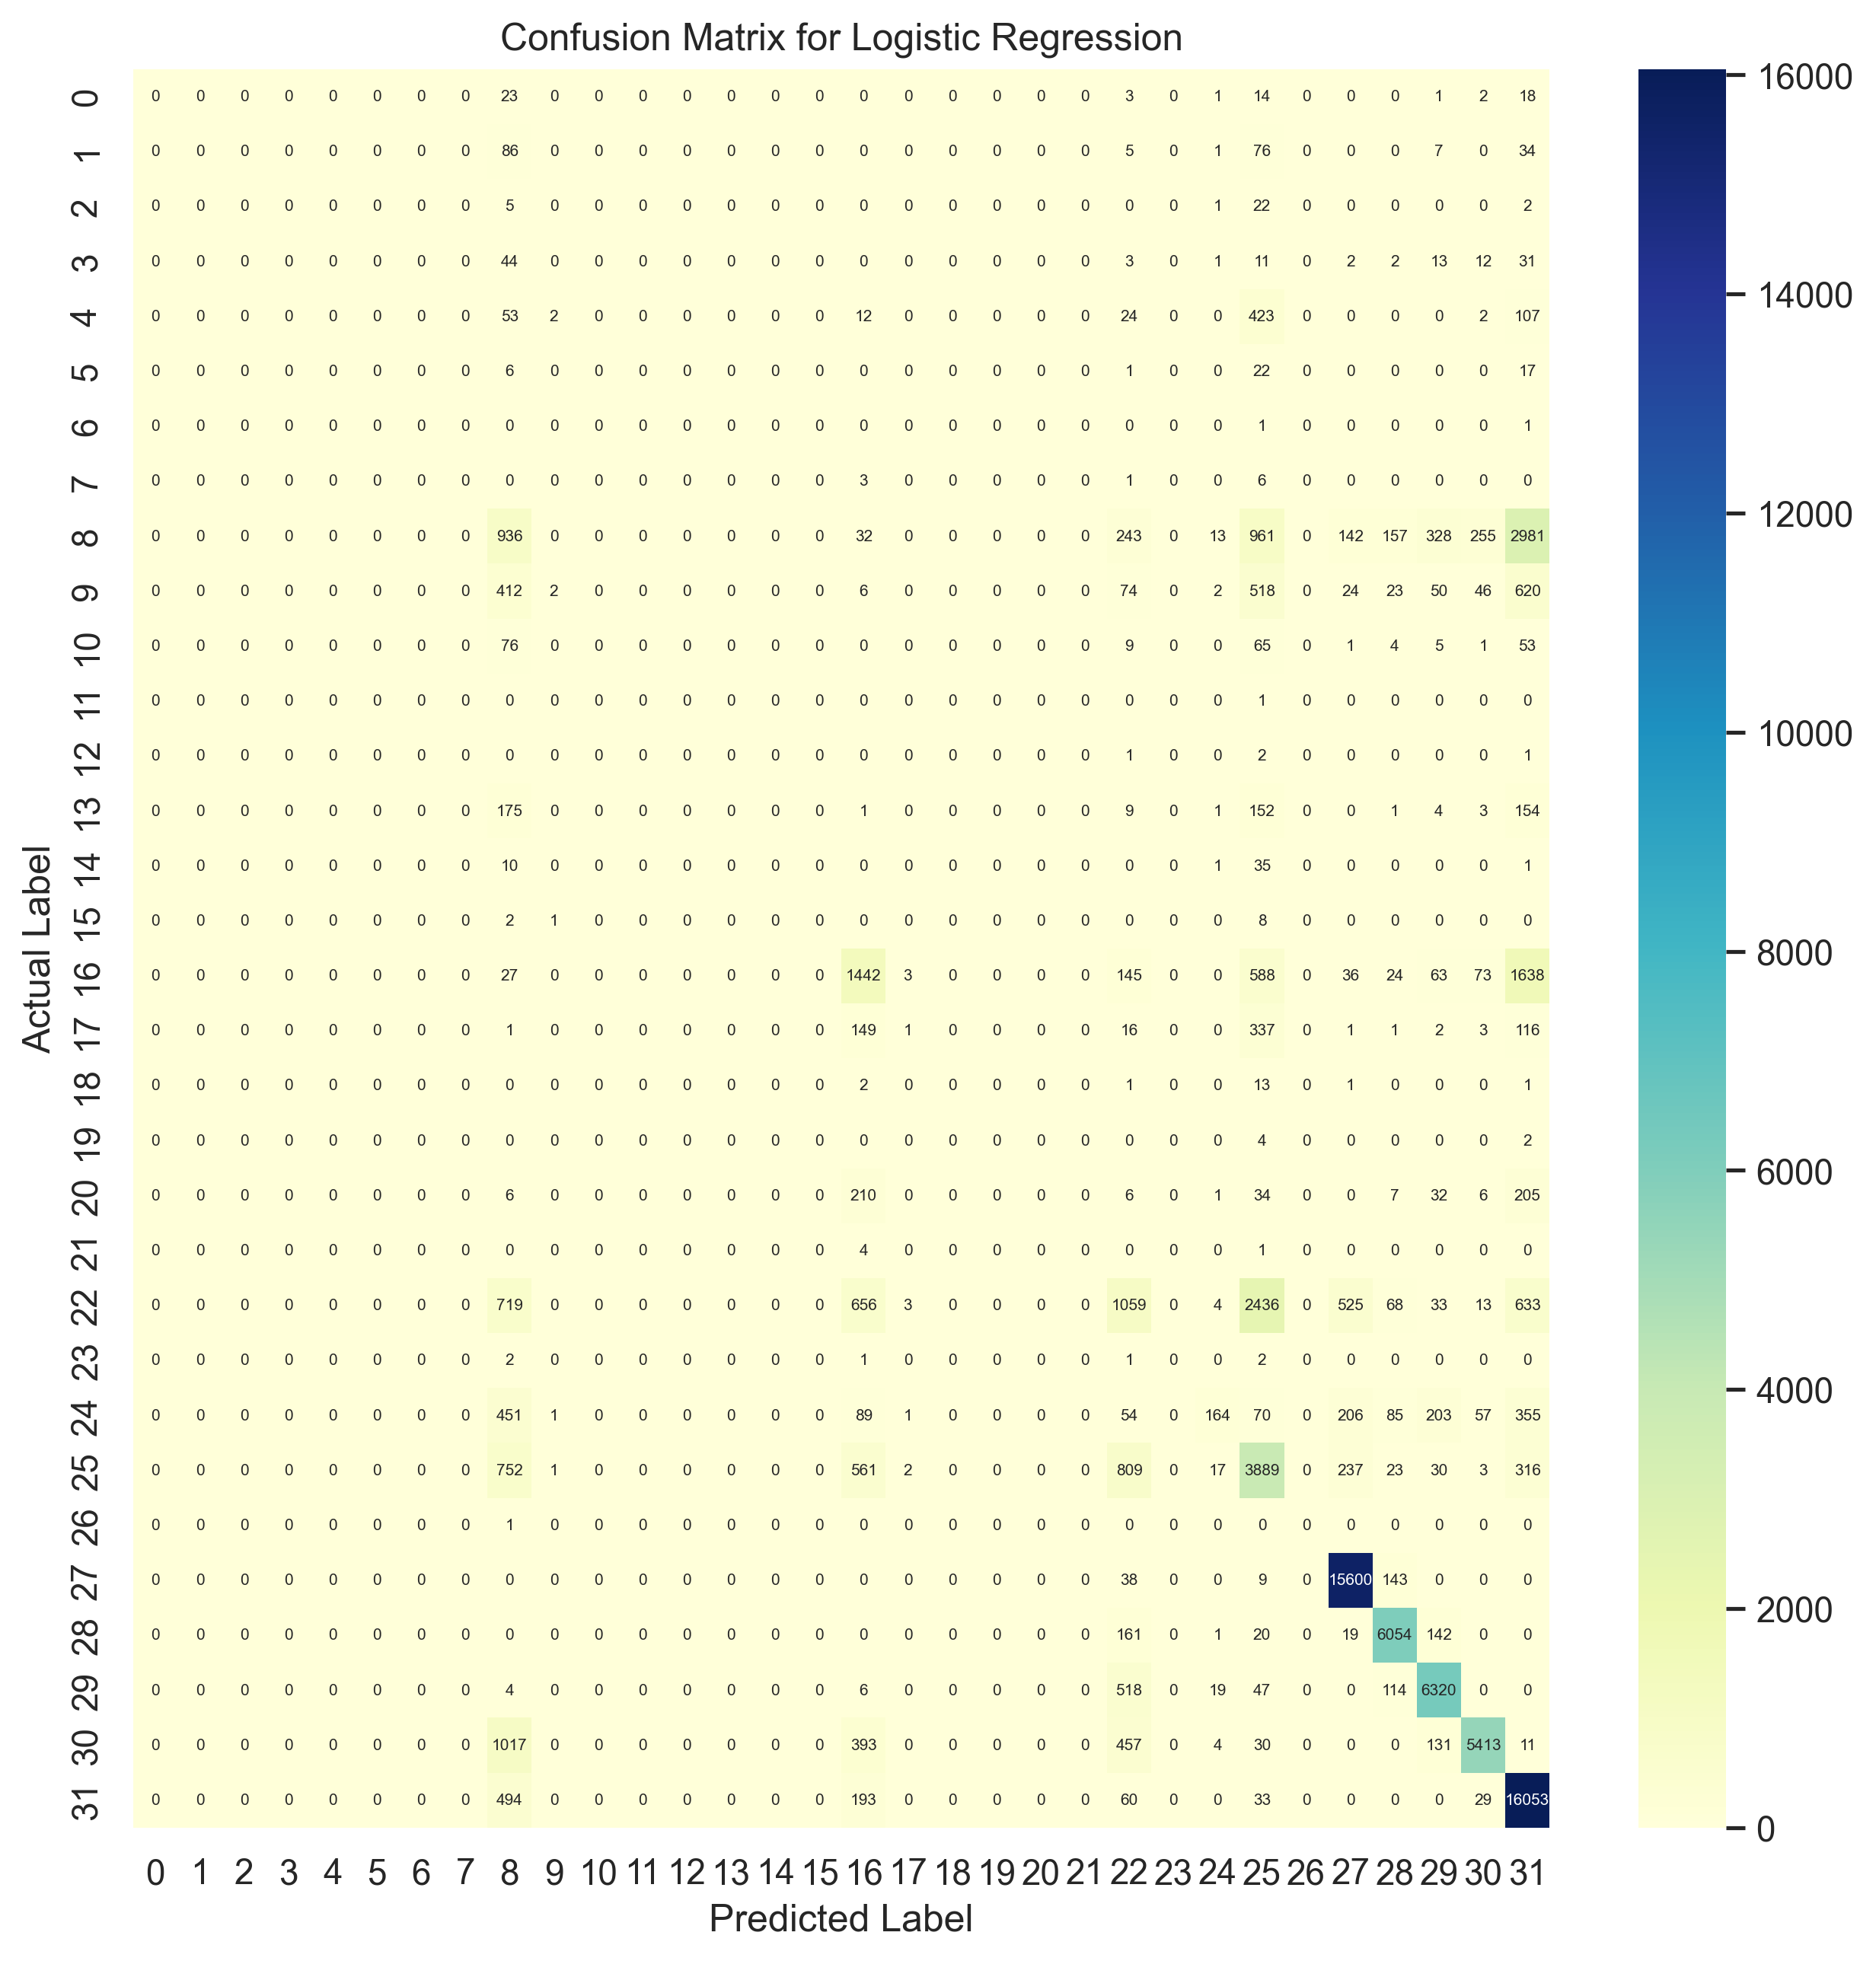

In [71]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(yc_test, y_pred)

# Confusion Matrix Plot
# Shrink the text in the confusion matrix
plt.rcParams['font.size'] = '5'
plt.figure(figsize=(10, 10), dpi=300)
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu" ,fmt='g')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()


#### Decision Tree Classifier

In [76]:
#### Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier().fit(Xc_train, yc_train)
y_pred = dt_clf.predict(Xc_test)
print('Accuracy of Decision Tree classifier on test set: {:.2f}'.format(dt_clf.score(Xc_test, yc_test)))


Accuracy of Decision Tree classifier on test set: 0.67


#### Random Forest Classifier

In [77]:
#### Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier().fit(Xc_train, yc_train)
y_pred = rf_clf.predict(Xc_test)
print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(rf_clf.score(Xc_test, yc_test)))


Accuracy of Random Forest classifier on test set: 0.74


#### k-Nearest Neighbors Classifier

In [79]:
#### k-Nearest Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier().fit(Xc_train, yc_train)
y_pred = knn_clf.predict(Xc_test)
print('Accuracy of k-Nearest Neighbors classifier on test set: {:.2f}'.format(knn_clf.score(Xc_test, yc_test)))

Accuracy of k-Nearest Neighbors classifier on test set: 0.72


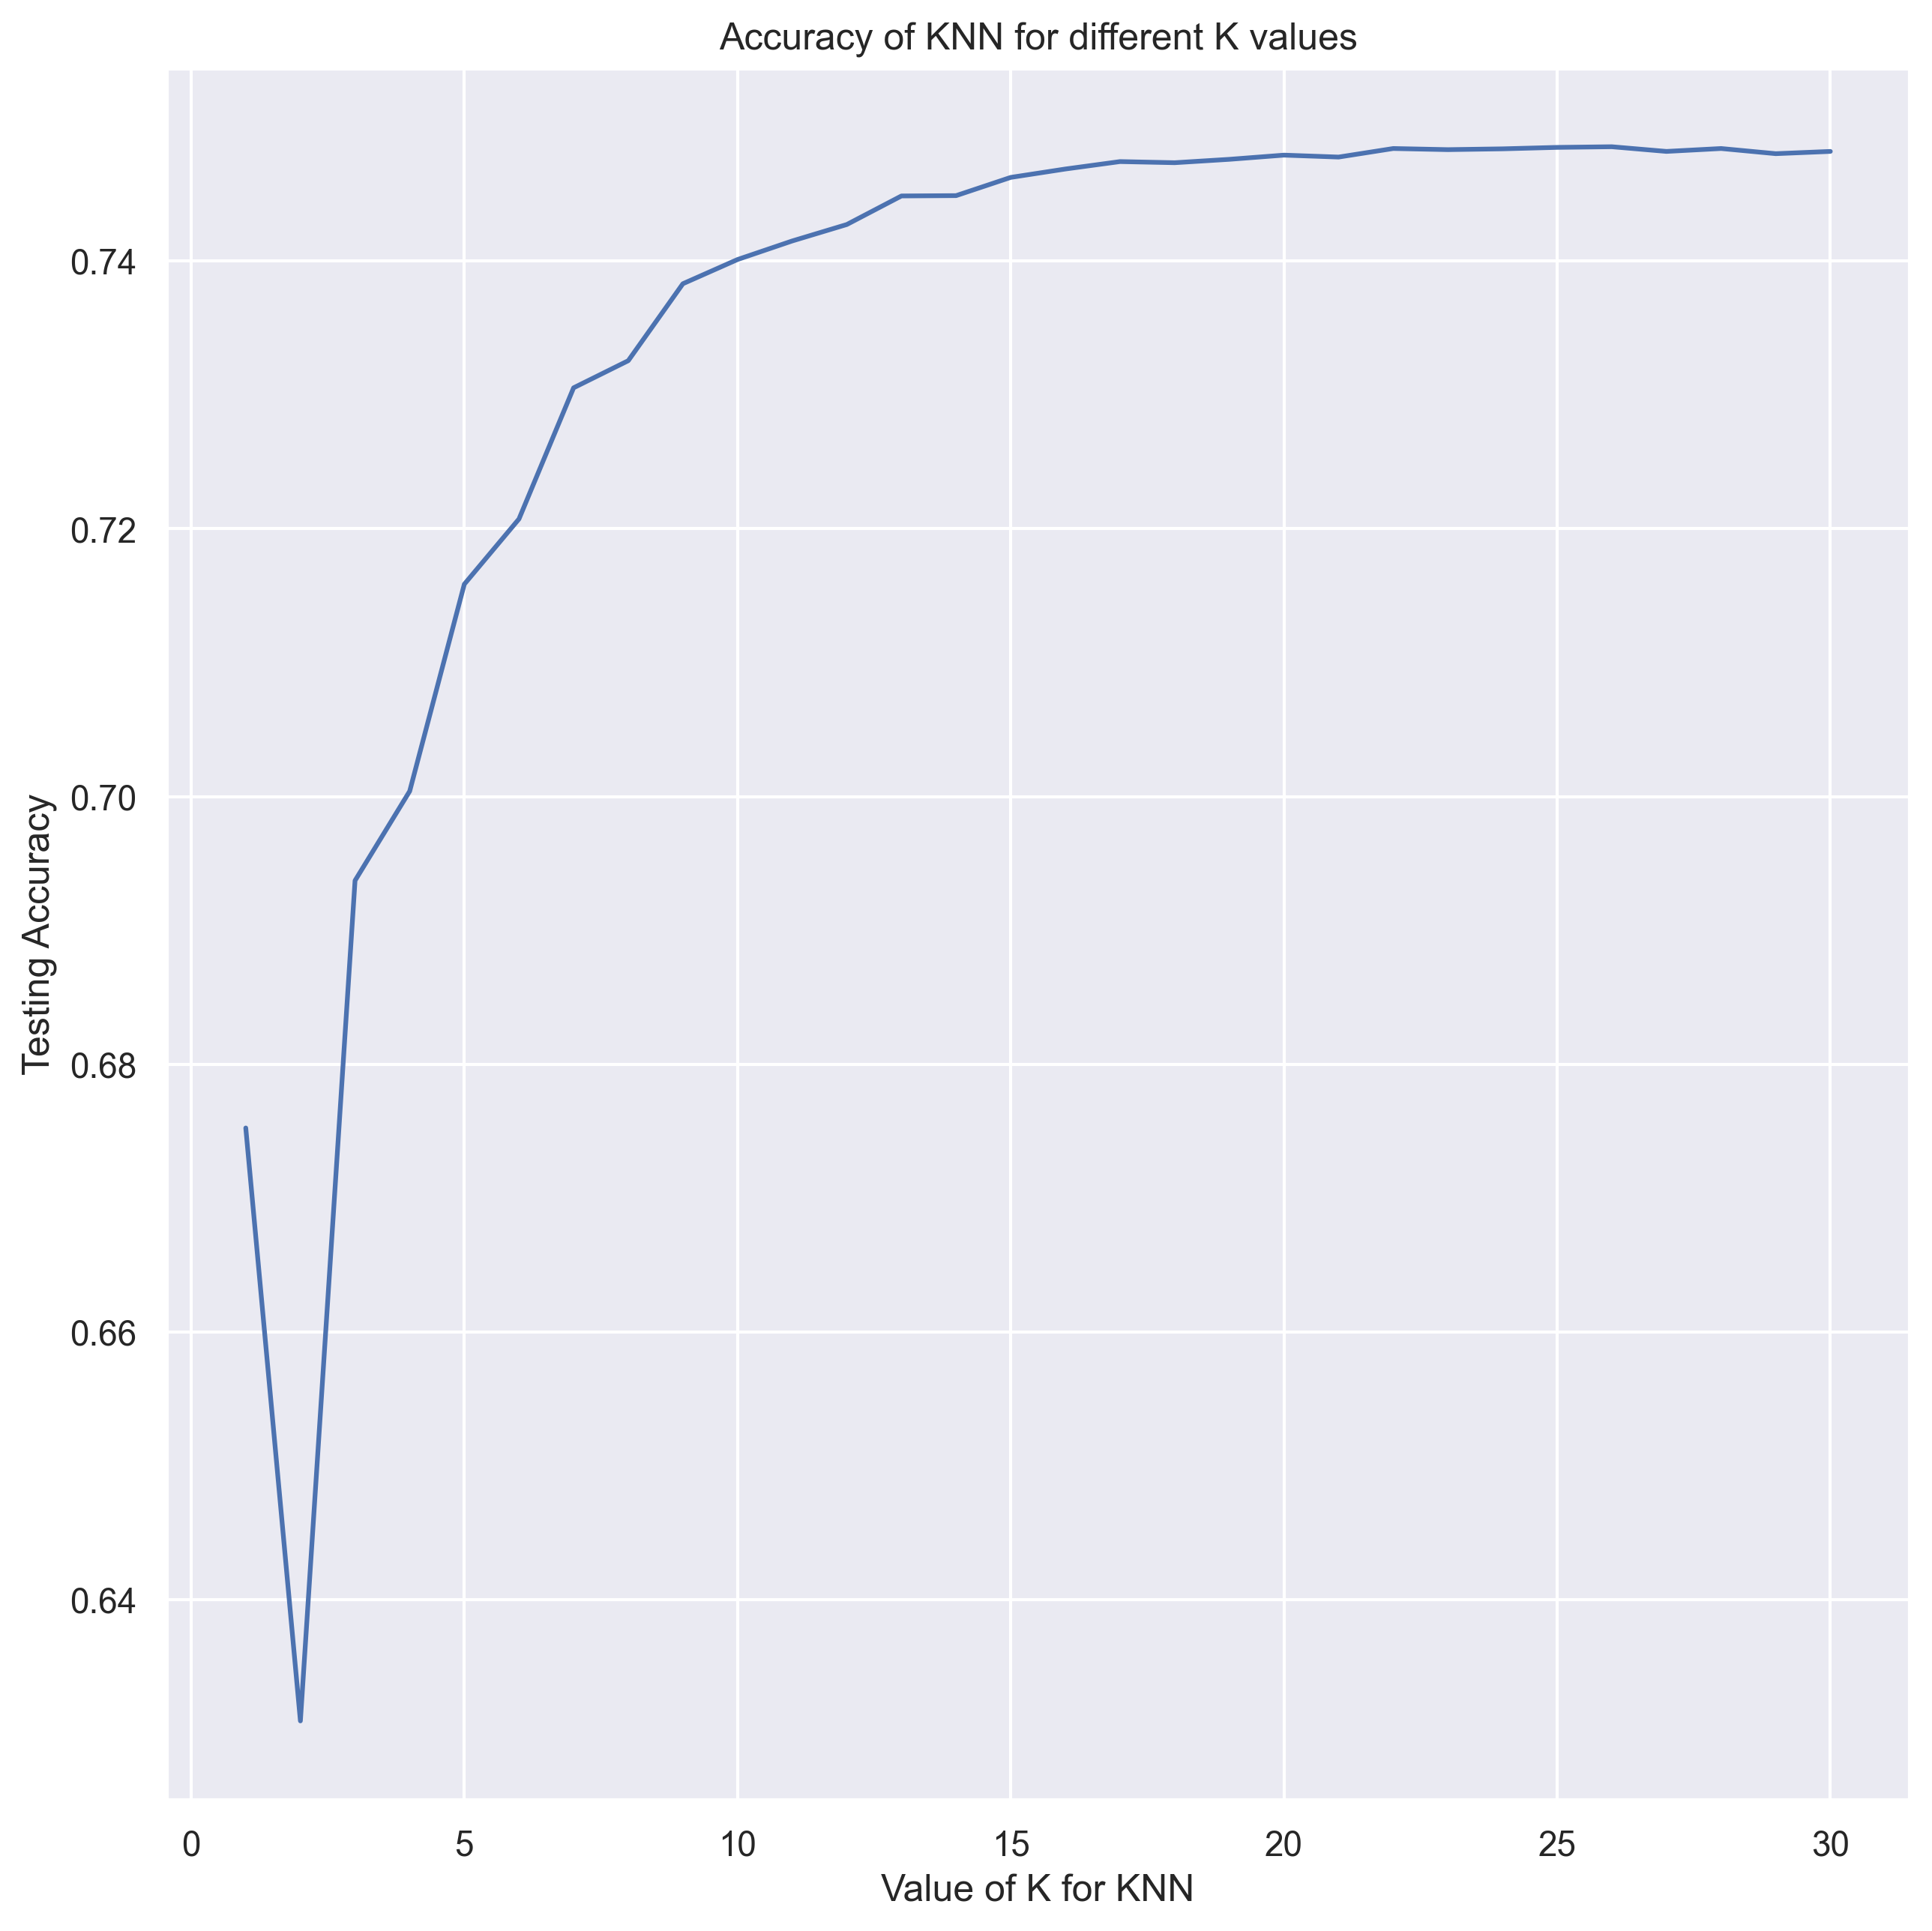

In [81]:
# knn graph for all k
k_range = range(1, 31)
scores = []
for k in k_range:
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    knn_clf.fit(Xc_train, yc_train)
    scores.append(knn_clf.score(Xc_test, yc_test))

plt.figure(figsize=(10, 10), dpi=300)
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.title('Accuracy of KNN for different K values')
plt.show()


#### Naive Bayes Classifier

In [82]:
#### Naive Bayes Classifier

from sklearn.naive_bayes import GaussianNB
nb_clf = GaussianNB().fit(Xc_train, yc_train)
y_pred = nb_clf.predict(Xc_test)
print('Accuracy of Naive Bayes classifier on test set: {:.2f}'.format(nb_clf.score(Xc_test, yc_test)))

Accuracy of Naive Bayes classifier on test set: 0.64


#### Neural Networks Classifier

In [102]:
#### Neural Networks Classifier using Keras

cmodel = Sequential()
cmodel.add(Dense(64, activation='relu', input_dim=8))
cmodel.add(Dense(64, activation='relu'))
cmodel.add(Dense(32, activation='softmax'))

cmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', 'sparse_categorical_crossentropy', 'mean_squared_error'])

cmodel.fit(Xc_train, yc_train, epochs=5, batch_size=64)


# Accuracy on the test set
score = cmodel.evaluate(Xc_test, yc_test,verbose=1)
print(score)

Epoch 1/5


2024-01-02 08:06:18.814631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5186/5186 [==============================] - 35s 7ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - sparse_categorical_crossentropy: 0.0000e+00 - mean_squared_error: 556325.4375
Epoch 2/5
5186/5186 [==============================] - 34s 7ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - sparse_categorical_crossentropy: 0.0000e+00 - mean_squared_error: 556324.8125
Epoch 3/5
5186/5186 [==============================] - 38s 7ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - sparse_categorical_crossentropy: 0.0000e+00 - mean_squared_error: 556325.2500
Epoch 4/5
5186/5186 [==============================] - 36s 7ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - sparse_categorical_crossentropy: 0.0000e+00 - mean_squared_error: 556323.8750
Epoch 5/5
  20/2593 [..............................] - ETA: 14s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - sparse_categorical_crossentropy: 0.0000e+00 - mean_squared_error: 555920.8125

2024-01-02 08:09:17.796567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2593/2593 [==============================] - 13s 5ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - sparse_categorical_crossentropy: 0.0000e+00 - mean_squared_error: 556067.2500
[0.0, 0.0, 0.0, 556067.25]


#### Gradient Boosting Models

In [104]:
#### Gradient Boosting Models   

from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(verbose=1).fit(Xc_train, yc_train)
y_pred = gb_clf.predict(Xc_test)
print('Accuracy of Gradient Boosting classifier on test set: {:.2f}'.format(gb_clf.score(Xc_test, yc_test)))

      Iter       Train Loss   Remaining Time 
         1           2.2528           16.85m
         2 35670419125700345662119468325185654034343825175907001072635322308870749028352.0000           17.12m
         3 16375120322960551709222959517397907538100686988843116976877246069979443431918110171631184907157904631372070486700199321962492141768802304.0000           17.11m
         4 9393836840172510796584361367075003743967036656964048622679657922558363439608692082611327295479477125271341904493027288878328659581843449839616.0000           16.96m


KeyboardInterrupt: 

In [109]:
#### XGBoost Classifier Implementation
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
ycl_train = le.fit_transform(yc_train)
ycl_test = le.fit_transform(yc_test)

from xgboost import XGBClassifier
xgb_clf = XGBClassifier().fit(Xc_train, ycl_train)
y_pred = xgb_clf.predict(Xc_test)
print('Accuracy of XGBoost classifier on test set: {:.2f}'.format(xgb_clf.score(Xc_test, ycl_test)))


Accuracy of XGBoost classifier on test set: 0.03


#### Adaboost

In [110]:
#### AdaBoost Classifier Implementation
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier().fit(Xc_train, yc_train)
y_pred = ada_clf.predict(Xc_test)
print('Accuracy of AdaBoost classifier on test set: {:.2f}'.format(ada_clf.score(Xc_test, yc_test)))


Accuracy of AdaBoost classifier on test set: 0.39


#### Categorical Naïve Bayes

In [122]:
#### Categorical Naïve Bayes Classifier Implementation
from sklearn.naive_bayes import CategoricalNB
catnb_clf = CategoricalNB(min_categories=8).fit(Xc_train, yc_train)
y_pred = catnb_clf.predict(Xc_test)
#print('Accuracy of Categorical Naive Bayes classifier on test set: {:.2f}'.format(catnb_clf.score(Xc_test, yc_test)))

IndexError: index 1049 is out of bounds for axis 1 with size 1049

#### Ensemble Methods

In [123]:
#### Ensemble Methods - Bagging Classifier Implementation
from sklearn.ensemble import BaggingClassifier
bag_clf = BaggingClassifier().fit(Xc_train, yc_train)
y_pred = bag_clf.predict(Xc_test)
print('Accuracy of Bagging classifier on test set: {:.2f}'.format(bag_clf.score(Xc_test, yc_test)))


Accuracy of Bagging classifier on test set: 0.73
